# Pipeline: Classifier Models - Reliance
## 1. Introduction
Predicting the direction of stock prices allows traders to classify stocks as Buy if the price will increase 'n' days in the future, or Sell if it will decrease.

A pipeline of ten classifier models will be created to streamline the selection process. After a spot check of the models the top three will be selected based on evaluation metrics in the classification report. Grid Search cross validation will then be used to find the best parameters for tuning the models, and confusion matrices will be plotted to better visualise performance.

## 2. Install/import libraries

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

# Importing the 10 models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## 3. Import data
Ten years of AstraZeneca stock data will be downloaded from Yahoo! Finance using the yfinance API.

In [33]:
r_df = yf.download("RELIANCE.NS", start="2010-01-01", end="2022-02-15")[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)

[*********************100%***********************]  1 of 1 completed


In [34]:
# Create Dataframe for Adjusted Close prices

reliance_adj = r_df[['Adj Close']]
reliance_adj

,Adj Close
Date,
2010-01-04,484.27
2010-01-05,482.10
2010-01-06,489.89
2010-01-07,498.02
2010-01-08,496.72
...,...
2022-02-08,2356.05
2022-02-09,2383.50
2022-02-10,2381.05


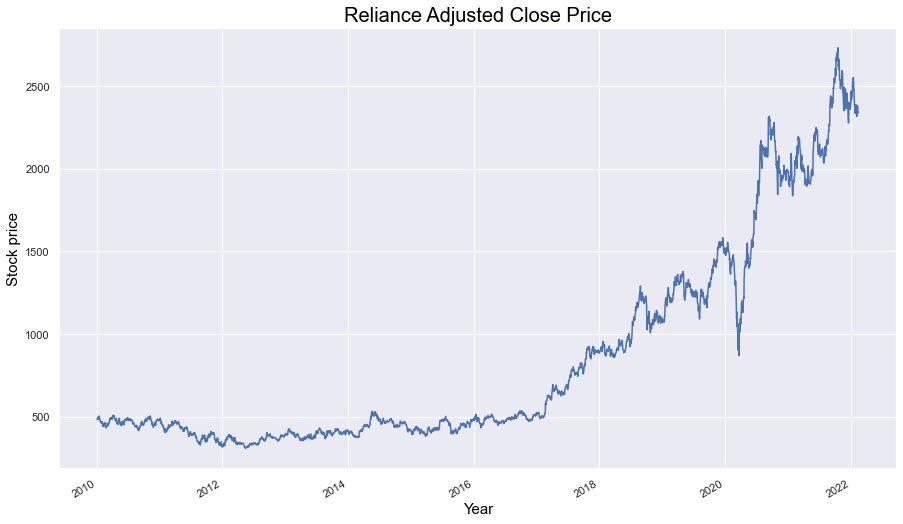

In [36]:
# Plot Adjusted Close price
reliance_adj['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Reliance Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## 4. Feature engineering
The Adjusted Close price will be used to create other features such as exponential moving averages for various time spans assigning a greater weight to the most recent price observations.

In [6]:
# Calculate moving averages for features

reliance_adj['ema50'] = reliance_adj['Adj Close'] / reliance_adj['Adj Close'].ewm(50).mean()
reliance_adj['ema21'] = reliance_adj['Adj Close'] / reliance_adj['Adj Close'].ewm(21).mean()
reliance_adj['ema15'] = reliance_adj['Adj Close'] / reliance_adj['Adj Close'].ewm(14).mean()
reliance_adj['ema5'] = reliance_adj['Adj Close'] / reliance_adj['Adj Close'].ewm(5).mean()

reliance_adj

,Adj Close,ema50,ema21,ema15,ema5
Date,,,,,
2010-01-04,484.27,1.000000,1.000000,1.000000,1.000000
2010-01-05,482.10,0.997777,0.997807,0.997832,0.997958
2010-01-06,489.89,1.009131,1.009025,1.008935,1.008465
2010-01-07,498.02,1.019088,1.018742,1.018449,1.016951
2010-01-08,496.72,1.012967,1.012516,1.012139,1.010272
...,...,...,...,...,...
2022-02-08,2356.05,0.980692,0.976031,0.980222,0.993959
2022-02-09,2383.50,0.992272,0.987968,0.992195,1.004612
2022-02-10,2381.05,0.991422,0.987538,0.991758,1.002981


We will also create a function for predicting 'n' days into the future to see if price has increased (1) or decreased (0)

In [7]:
def buy_sell_pred(data, forecast_out):
    """
    Function to produce the 'truth' values

    :param data: historical stock data
    :param forecast_out: Adjusted Close price is shifted 'n' days ahead 
                         to see if price has increased/Buy signal (1) or decreased/Sell signal (0) 
    :return: data with Prediction column containing Buy/Sell signal
    """
    prediction = np.where(data.shift(-forecast_out)['Adj Close'] > data['Adj Close'], 1.0, 0.0)
    data['n days ahead'] = data.shift(-forecast_out)['Adj Close']
    data['Prediction'] = prediction

    return data

reliance_adj = buy_sell_pred(reliance_adj, forecast_out=5)
del (reliance_adj['Adj Close'])
reliance_adj = reliance_adj.dropna()
reliance_adj

,ema50,ema21,ema15,ema5,n days ahead,Prediction
Date,,,,,,
2010-01-04,1.000000,1.000000,1.000000,1.000000,486.97,1.0
2010-01-05,0.997777,0.997807,0.997832,0.997958,488.25,1.0
2010-01-06,1.009131,1.009025,1.008935,1.008465,490.16,1.0
2010-01-07,1.019088,1.018742,1.018449,1.016951,505.07,1.0
2010-01-08,1.012967,1.012516,1.012139,1.010272,500.14,1.0
...,...,...,...,...,...,...
2022-02-01,0.987782,0.978348,0.980134,0.988012,2356.05,0.0
2022-02-02,0.989994,0.981220,0.983304,0.991675,2383.50,0.0
2022-02-03,0.977639,0.969928,0.972504,0.982321,2381.05,1.0


In [8]:
# Remove first row 

reliance_adj = reliance_adj.iloc[1:]
reliance_adj.head()

,ema50,ema21,ema15,ema5,n days ahead,Prediction
Date,,,,,,
2010-01-05,0.997777,0.997807,0.997832,0.997958,488.25,1.0
2010-01-06,1.009131,1.009025,1.008935,1.008465,490.16,1.0
2010-01-07,1.019088,1.018742,1.018449,1.016951,505.07,1.0
2010-01-08,1.012967,1.012516,1.012139,1.010272,500.14,1.0
2010-01-11,0.994287,0.994007,0.993782,0.992820,495.07,1.0


In [9]:
# Number of bullish and bearish days

reliance_adj['Prediction'].value_counts()

1.0    1597
0.0    1388
Name: Prediction, dtype: int64

## 5. Splitting the data
The target variable (y) will be the Prediction column with the Buy/Sell signals.

In [10]:
X = reliance_adj.drop(['Prediction'], 1)
y = reliance_adj.Prediction

To avoid look-ahead bias when splitting time series data into training and test sets we will use sklearn's TimeSeriesSplit class. Successive training sets are supersets of those that come before them so that the model is not trained on data it has already seen. Randomised data rather than walk-forward validation would lead to overfitting.

In [11]:
tscv = TimeSeriesSplit(n_splits=3)

In [12]:
for train_ind, test_ind in tscv.split(X):
    # Split into training and test sets
    X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
    y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

    print(f'Train is from {X.iloc[train_ind].index.min()} to {X.iloc[train_ind].index.max()}. ')
    print(f'Test is from {X.iloc[test_ind].index.min()} to {X.iloc[test_ind].index.max()}. ')
    print("")

Train is from 2010-01-05 00:00:00 to 2013-01-09 00:00:00. 
Test is from 2013-01-10 00:00:00 to 2016-01-21 00:00:00. 

Train is from 2010-01-05 00:00:00 to 2016-01-21 00:00:00. 
Test is from 2016-01-22 00:00:00 to 2019-01-29 00:00:00. 

Train is from 2010-01-05 00:00:00 to 2019-01-29 00:00:00. 
Test is from 2019-01-30 00:00:00 to 2022-02-07 00:00:00. 



In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2239, 5)
(2239,)
(746, 5)
(746,)


## 6. Creating a pipeline
A pipeline will be created for each of the ten models which scales the data using StandardScaler() before running the model using its default parameters.

In [14]:
# Adaboost
pipe_ada = Pipeline([('scale', StandardScaler()), ('clf', AdaBoostClassifier())])

# Gradient Boost
pipe_gb  = Pipeline([('scale', StandardScaler()), ('clf', GradientBoostingClassifier())])

# Random Forest
pipe_rf  = Pipeline([('scale', StandardScaler()), ('clf', RandomForestClassifier())])

# Decision Tree
pipe_dt  = Pipeline([('scale', StandardScaler()), ('clf', DecisionTreeClassifier())])

# Dummy (Baseline)
pipe_dum = Pipeline([('scale', StandardScaler()), ('clf', DummyClassifier())])

# K Nearest Neighbors
pipe_knn = Pipeline([('scale', StandardScaler()), ('clf', KNeighborsClassifier())])

# Logistic Regression
pipe_lr  = Pipeline([('scale', StandardScaler()), ('clf', LogisticRegression())])

# Naive Bayes
pipe_nb  = Pipeline([('scale', StandardScaler()), ('clf', GaussianNB())])

# Support Vector Machine
pipe_svm = Pipeline([('scale', StandardScaler()), ('clf', SVC())])

# XGBoost
#pipe_xgb = Pipeline([('scale', StandardScaler()), ('clf', XGBClassifier())])
pipe_xgb = Pipeline([('scale', StandardScaler()), ('clf', XGBClassifier(eval_metric='mlogloss'))])

A list of pipelines and model names will be used to create a dictionary.

In [15]:
pipelines = [pipe_ada, pipe_gb, pipe_rf, pipe_dt, pipe_dum, 
             pipe_knn, pipe_lr, pipe_nb, pipe_svm, pipe_xgb]

models = ['Adaboost', 
          'GradientBoost', 
          'RandomForest', 
          'DecisionTree', 
          'Dummy(Baseline)', 
          'KNN', 
          'binary:logistic',
          'NaiveBayes',
          'SupportVectorMachine',
          'XGBoost']

# Zipping the strings and pipelines together and creating a dictionary
model_pipelines = dict(zip(models, pipelines))

### 6.1 Fit and train each model
A loop will be created to iterate over each pipeline to fit and train each model to the training data.

In [16]:
# Looping through each Pipeline to fit and train each model
for name, pipe in model_pipelines.items():
    print(pipe)
    pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('clf', AdaBoostClassifier())])
Pipeline(steps=[('scale', StandardScaler()),
                ('clf', GradientBoostingClassifier())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', RandomForestClassifier())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', DecisionTreeClassifier())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', DummyClassifier())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', KNeighborsClassifier())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', LogisticRegression())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', GaussianNB())])
Pipeline(steps=[('scale', StandardScaler()), ('clf', SVC())])
Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
          

### 6.2 Classification report
A classification report for each model based on accuracy score will be produced and the top three models listed in descending order.

In [17]:
# Dictionary containing the model names and their scores 
models_acc = {}

# Looping through each model's predictions and getting their classification reports
for name, pipe in model_pipelines.items():
    print('\n'+ name + ' (Accuracy Score):')
    
    # Classification Report
    report = classification_report(y_test, pipe.predict(X_test), target_names=['Sell', 'Buy'], output_dict=True)
    acc = report['accuracy']
    
    # Assigning to the Dictionary
    models_acc[name] = acc
    
    print(acc) 


Adaboost (Accuracy Score):
0.5563002680965148

GradientBoost (Accuracy Score):
0.5509383378016086

RandomForest (Accuracy Score):
0.5509383378016086

DecisionTree (Accuracy Score):
0.5335120643431636

Dummy(Baseline) (Accuracy Score):
0.5455764075067024

KNN (Accuracy Score):
0.532171581769437

binary:logistic (Accuracy Score):
0.5455764075067024

NaiveBayes (Accuracy Score):
0.5455764075067024

SupportVectorMachine (Accuracy Score):
0.5455764075067024

XGBoost (Accuracy Score):
0.546916890080429


In [18]:
# Finding the Top 3 Models
for i in sorted(models_acc, key=models_acc.get, reverse=True)[:3]:
    print(i, models_acc[i])

Adaboost 0.5563002680965148
GradientBoost 0.5509383378016086
RandomForest 0.5509383378016086


## 7. Tune hyperparameters
We can now optimise the top three models by creating a list of parameters with various values to iterate through in search of the best combinations.

In [19]:
# Creating parameters to iterate through for each classifier

nb_params = {"clf__var_smoothing": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

gb_params = {"clf__n_estimators":[5,50,250,500],
             "clf__max_depth":[1,3,5,7,9],
             "clf__learning_rate":[0.01,0.1,1,10,100]}

ada_params = {'clf__n_estimators': np.arange(10,300,10), #[50, 100],
              'clf__learning_rate': [0.01,0.05,0.1,0.3,1]}

In [20]:
# # Creating parameters to iterate through for each classifier

# nb_params = {"clf__var_smoothing": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

# gb_params = {"clf__n_estimators":[5,50,250,500],
#              "clf__max_depth":[1,3,5,7,9],
#              "clf__learning_rate":[0.01,0.1,1,10,100]}

# ada_params = {'clf__n_estimators': np.arange(10,300,10), #[50, 100],
#               'clf__learning_rate': [0.01,0.05,0.1,0.3,1]}

Next we need to create a dictionary of the pipeline and parameters for each model.

In [21]:
# Creating a dictionary for the top 3 classifiers with their respective parameters

top3 = {'RandomForest': [pipe_nb, nb_params],
        'GradientBoost': [pipe_gb, gb_params],
        'AdaBoost': [pipe_ada, ada_params]}

### 7.1 Grid search
Now we can grid search all possible combinations of the parameters to find the best parameters for each model and save the best performing model to a dictionary.

In [22]:
# Dictionary storing the best estimators for each classifier 
best_estimators = {}

# Grid Searching each classifier
for name, vals in top3.items():
    print(name + ' -'*30)
    
    # Grid Searching 
    gs = GridSearchCV(vals[0], vals[1] , cv=tscv, return_train_score=True, verbose=2, scoring='accuracy')
    gs.fit(X_train, y_train)
    
    # Printing out the best parameters for the selected classifier
    print(name+' Best Parameters: ', gs.best_params_)
    
    # Saving the best estimators/tuned models
    best_estimators[name+'_clf'] = gs.best_estimator_

RandomForest - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ............................clf__var_smoothing=0.01; total time=   0.0s
[CV] END ............................clf__var_smoothing=0.01; total time=   0.0s
[CV] END ............................clf__var_smoothing=0.01; total time=   0.0s
[CV] END ...........................clf__var_smoothing=0.001; total time=   0.0s
[CV] END ...........................clf__var_smoothing=0.001; total time=   0.0s
[CV] END ...........................clf__var_smoothing=0.001; total time=   0.0s
[CV] END ..........................clf__var_smoothing=0.0001; total time=   0.0s
[CV] END ..........................clf__var_smoothing=0.0001; total time=   0.0s
[CV] END ..........................clf__var_smoothing=0.0001; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1e-05; total time=   0.0s
[CV] END ...........................clf__var_smoothing=1

[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=50; total time=   0.1s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=50; total time=   0.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=50; total time=   0.4s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=250; total time=   1.0s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=250; total time=   1.7s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=250; total time=   2.5s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=500; total time=   2.3s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=500; total time=   3.7s
[CV] END clf__learning_rate=0.01, clf__max_depth=9, clf__n_estimators=500; total time=   5.1s
[CV] END clf__learning_rate=0.1, clf__max_depth=1, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=0.1, clf__max_depth=1, clf__n_estimato

[CV] END clf__learning_rate=1, clf__max_depth=3, clf__n_estimators=500; total time=   0.4s
[CV] END clf__learning_rate=1, clf__max_depth=3, clf__n_estimators=500; total time=   0.7s
[CV] END clf__learning_rate=1, clf__max_depth=3, clf__n_estimators=500; total time=   1.2s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=50; total time=   0.0s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=50; total time=   0.1s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=50; total time=   0.1s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=250; total time=   0.3s
[CV] END clf__learning_rate=1, clf__max_depth=5, clf__n_estimators=250; total time=   0.7s
[CV] END

[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=50; total time=   0.2s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=50; total time=   0.4s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=250; total time=   0.5s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=250; total time=   1.6s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=250; total time=   2.7s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=500; total time=   1.0s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=500; total time=   3.7s
[CV] END clf__learning_rate=10, clf__max_depth=9, clf__n_estimators=500; total time=   4.5s
[CV] END clf__learning_rate=100, clf__max_depth=1, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=100, clf__max_depth=1, clf__n_estimators=5; total time=   0.0s
[CV] END clf__learning_rate=100, clf__max_depth=1, clf__n_estimators=5; total time= 

[CV] END ......clf__learning_rate=0.01, clf__n_estimators=80; total time=   0.1s
[CV] END ......clf__learning_rate=0.01, clf__n_estimators=80; total time=   0.1s
[CV] END ......clf__learning_rate=0.01, clf__n_estimators=90; total time=   0.0s
[CV] END ......clf__learning_rate=0.01, clf__n_estimators=90; total time=   0.1s
[CV] END ......clf__learning_rate=0.01, clf__n_estimators=90; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=100; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=100; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=100; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=110; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=110; total time=   0.1s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=110; total time=   0.2s
[CV] END .....clf__learning_rate=0.01, clf__n_estimators=120; total time=   0.1s
[CV] END .....clf__learning_

[CV] END .....clf__learning_rate=0.05, clf__n_estimators=130; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=130; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=140; total time=   0.1s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=140; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=140; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=150; total time=   0.1s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=150; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=150; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=160; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=160; total time=   0.2s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=160; total time=   0.3s
[CV] END .....clf__learning_rate=0.05, clf__n_estimators=170; total time=   0.2s
[CV] END .....clf__learning_

[CV] END ......clf__learning_rate=0.1, clf__n_estimators=180; total time=   0.2s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=180; total time=   0.3s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=190; total time=   0.2s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=190; total time=   0.3s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=190; total time=   0.3s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=200; total time=   0.2s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=200; total time=   0.3s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=200; total time=   0.4s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=210; total time=   0.2s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=210; total time=   0.3s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=210; total time=   0.4s
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=220; total time=   0.2s
[CV] END ......clf__learning

[CV] END ......clf__learning_rate=0.3, clf__n_estimators=230; total time=   0.3s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=230; total time=   0.5s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=240; total time=   0.3s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=240; total time=   0.4s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=240; total time=   0.5s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=250; total time=   0.3s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=250; total time=   0.4s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=250; total time=   0.5s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=260; total time=   0.3s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=260; total time=   0.4s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=260; total time=   0.5s
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=270; total time=   0.3s
[CV] END ......clf__learning

[CV] END ........clf__learning_rate=1, clf__n_estimators=280; total time=   0.4s
[CV] END ........clf__learning_rate=1, clf__n_estimators=280; total time=   0.5s
[CV] END ........clf__learning_rate=1, clf__n_estimators=290; total time=   0.3s
[CV] END ........clf__learning_rate=1, clf__n_estimators=290; total time=   0.5s
[CV] END ........clf__learning_rate=1, clf__n_estimators=290; total time=   0.6s
AdaBoost Best Parameters:  {'clf__learning_rate': 0.05, 'clf__n_estimators': 80}


### 7.2 Classification Report for each Tuned Model

In [23]:
# Looping through each tuned model's predictions and getting their classification reports
for name, pipe in best_estimators.items():
    print('\nTuned '+ name + ' (Accuracy Score):')
    
    report = classification_report(y_test, pipe.predict(X_test), target_names=['Sell', 'Buy'], output_dict=True)
    print(report['accuracy'])


Tuned RandomForest_clf (Accuracy Score):
0.5455764075067024

Tuned GradientBoost_clf (Accuracy Score):
0.5428954423592494

Tuned AdaBoost_clf (Accuracy Score):
0.5428954423592494


## 8. Confusion Matrix
We will plot a confusion matrix for each tuned model to better visualise performance.

In [24]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Sell", "Buy"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

### 8.1 Confusion matrix for Gaussian Naive Bayes Classifier

### 8.1 Confusion matrix for RandomForest Classifier

In [25]:
# # Plot confusion matrix
# plot_confusion_matrix(y_test, best_estimators['NaiveBayes_clf'].predict(X_test), title="Confusion Matrix")
# np.set_printoptions(precision=1)
# plt.show()

# # Final Classification Report
# print(classification_report(y_test, best_estimators['NaiveBayes_clf'].predict(X_test), target_names=['Sell', 'Buy']))

In [26]:
# # Plot confusion matrix
# plot_confusion_matrix(y_test, best_estimators['RandomForest_clf'].predict(X_test), title="Confusion Matrix")
# np.set_printoptions(precision=1)
# plt.show()

# # Final Classification Report
# print(classification_report(y_test, best_estimators['RandomForest_clf'].predict(X_test), target_names=['Sell', 'Buy']))

The precision score is the 'exactness', or ability of the model to return only relevant instances. When a model makes a prediction, how often it is correct? Here it shows that the Buy class is being correctly classified 61% of the time and the Sell class 59% of the time.

### 8.2 Confusion matrix for Gradient Boosting Classifier

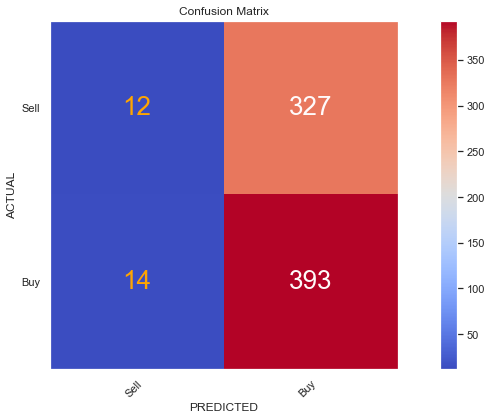

              precision    recall  f1-score   support

        Sell       0.46      0.04      0.07       339
         Buy       0.55      0.97      0.70       407

    accuracy                           0.54       746
   macro avg       0.50      0.50      0.38       746
weighted avg       0.51      0.54      0.41       746



In [27]:
# Plot confusion matrix
plot_confusion_matrix(y_test, best_estimators['GradientBoost_clf'].predict(X_test), title="Confusion Matrix")
np.set_printoptions(precision=1)
plt.show()

# Final Classification Report
print(classification_report(y_test, best_estimators['GradientBoost_clf'].predict(X_test), target_names=['Sell', 'Buy']))

### Conclusion:
<strong>The precision score shows that the Buy class is being correctly classified 46% of the time and the Sell class 55% of the time.</strong>

### 8.3 Confusion matrix for Adaptive Boosting Classifier

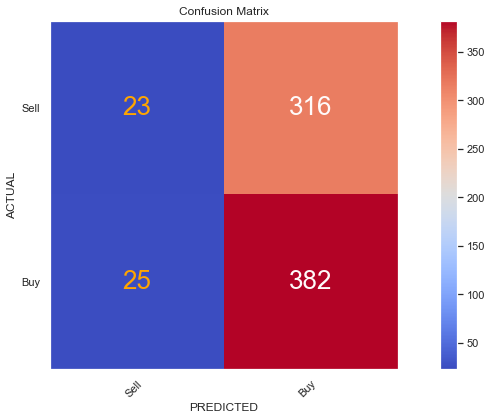

              precision    recall  f1-score   support

        Sell       0.48      0.07      0.12       339
         Buy       0.55      0.94      0.69       407

    accuracy                           0.54       746
   macro avg       0.51      0.50      0.41       746
weighted avg       0.52      0.54      0.43       746



In [28]:
# Plot confusion matrix
plot_confusion_matrix(y_test, best_estimators['AdaBoost_clf'].predict(X_test), title="Confusion Matrix")
np.set_printoptions(precision=1)
plt.show()

# Final Classification Report
print(classification_report(y_test, best_estimators['AdaBoost_clf'].predict(X_test), target_names=['Sell', 'Buy']))

### Conclusion:
The precision score shows that the Buy class is being correctly classified 55% of the time and the Sell class 48% of the time.